# Evaluation of the HPO dataset provided by Feurer et al.

In [18]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import config
import seaborn as sns
from utils import results_to_numpy, plot_results
sns.set()
print(config.ROOT_FOLDER)

/Users/alexander.prams/autotune


## Load datasets

In [19]:
with open(os.path.join(config.ROOT_FOLDER, 'experiments/results/hpo_dataset_optimizer_results.pickle'), 'rb') as handle:
    optimizer_results = pickle.load(handle)
    
with open(os.path.join(config.ROOT_FOLDER, 'experiments/results/combined_hpo_dataset_optimizer_results.pickle'), 'rb') as handle:
    combined_optimizer_results = pickle.load(handle)

with open(os.path.join(config.HPO_FOLDER, 'preprocessed_meta_data.pickle'), 'rb') as handle:
    meta_data = pickle.load(handle)

# Legacy support TODO: REMOVE
if 'meta' in optimizer_results:
    del optimizer_results['meta']
    
hpo_save_folder = os.path.join(config.PLOT_FOLDER, 'hpo')
os.makedirs(hpo_save_folder, exist_ok=True)

### Extract meta data

In [20]:
# Optimizer results dict has structure [optimizer.name][classifier_name][dataset_idx][rep_id] -> optimizer output
classifiers = list(optimizer_results.keys())
print("Classifiers: ", classifiers)

optimizers = list(optimizer_results[classifiers[0]].keys())
print("Optimizers: ", optimizers)

n_datasets = len(optimizer_results[classifiers[0]][optimizers[0]])
print("n_datasets: ", n_datasets)

n_reps_per_dataset = len(optimizer_results[classifiers[0]][optimizers[0]][0])
print("n_reps_per_dataset", n_reps_per_dataset)

n_steps_per_optimizer = len(optimizer_results[classifiers[0]][optimizers[0]][0][0])
print("n_steps_per_optimizer", n_steps_per_optimizer)

loss_ranges = meta_data['loss_ranges']
#print("loss ranges: ", loss_ranges)


Classifiers:  ['libsvm_svc', 'liblinear', 'random_forest']
Optimizers:  ['RandomSearch', 'TPE', 'GP_short', 'GA']
n_datasets:  42
n_reps_per_dataset 4
n_steps_per_optimizer 30


### Result preparation & Utils

In [21]:
def get_mean_std_min_losses_per_timestep(data, avg_datasets=False, t_0=0):
    """
    Calculate mean and standard deviation of the given experiment 
    :param data: shape [dataset_idx, iteration_idx, timesteps] if avg_datasets = True, else
    shape [iteration_idx, timesteps]
    :param avg_datasets: Bool indicating whether to average over datasets or not
    :param t_0: start time step
    :return: mean, std, 25 percentile, 75 percentile per timestep over experiment runs
    """
    min_losses = np.minimum.accumulate(data, axis=-1)
    min_losses = min_losses[:, :, t_0:] if avg_datasets else min_losses[:, t_0:]
    if avg_datasets:
        axis=(0, 1)
    else:
        axis=(0)
    avg_min_losses = np.percentile(min_losses, 50, axis=axis)#np.nanmean(min_losses, axis=axis)
    std_min_losses = np.nanstd(min_losses, axis=axis)
    lower_min_losses = np.percentile(min_losses, 25, axis=axis)
    upper_min_losses = np.percentile(min_losses, 75, axis=axis)
    #print("avg/std min_losses shape: ", avg_min_losses.shape, std_min_losses.shape)
    return avg_min_losses, std_min_losses, lower_min_losses, upper_min_losses
    

In [22]:
loss_per_time_step = results_to_numpy(optimizer_results)
cpu_time_per_opt_timestep = results_to_numpy(optimizer_results, result_idx=2, negative=False)
min_max_normalized_loss_per_time_step = {}
for c in list(loss_per_time_step.keys()):
    min_max_normalized_loss_per_time_step[c] = {}
    for o in list(loss_per_time_step[c].keys()):
        tmp_loss = loss_per_time_step[c][o]
        min_loss = loss_ranges[c][:, 0][:, None, None]
        max_loss = loss_ranges[c][:, 1][:, None, None]
        min_max_normalized_loss_per_time_step[c][o] = (tmp_loss - min_loss) / np.maximum(max_loss - min_loss, 1e-5)


### Get mean and standard deviation of provided sample run

In [23]:
t_0 = 10
for c in loss_per_time_step:
    plot_results(loss_per_time_step[c], dataset_idx=1 , t_0=t_0, 
                 save_file_name=os.path.join(hpo_save_folder, 
                                         'loss_per_time_step_' + c + '_t0_' + str(t_0)))

Plots, averaged=False , dataset_idx=1


Corrected TPE to TPE_short
Corrected TPE to TPE_short


Plots, averaged=False , dataset_idx=1
Corrected TPE to TPE_short
Corrected TPE to TPE_short


Plots, averaged=False , dataset_idx=1
Corrected TPE to TPE_short
Corrected TPE to TPE_short


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### CPU Time plot

Plots, averaged=False , dataset_idx=1
Corrected TPE to TPE_short
Corrected TPE to TPE_short


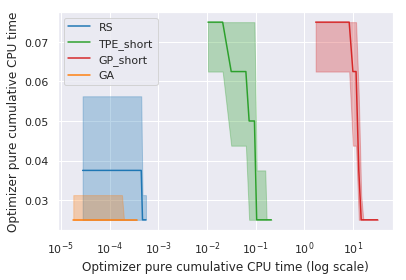

Plots, averaged=False , dataset_idx=1
Corrected TPE to TPE_short
Corrected TPE to TPE_short


<Figure size 432x288 with 0 Axes>

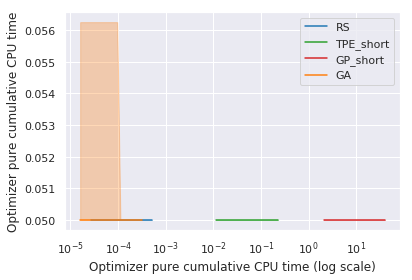

Plots, averaged=False , dataset_idx=1
Corrected TPE to TPE_short
Corrected TPE to TPE_short


<Figure size 432x288 with 0 Axes>

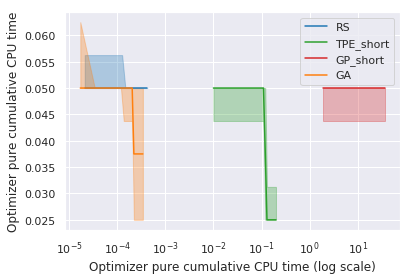

<Figure size 432x288 with 0 Axes>

In [24]:
for c in loss_per_time_step:
    plot_results(loss_per_time_step[c], X=cpu_time_per_opt_timestep[c], dataset_idx=1,
                 avg_datasets=False , t_0=10, use_log_scale_x=True, use_log_scale_y=False,
                 x_label="Optimizer pure cumulative CPU time")

Plots, averaged=True 
Corrected TPE to TPE_short
Corrected TPE to TPE_short


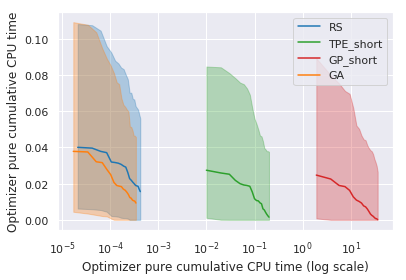

<Figure size 432x288 with 0 Axes>

In [25]:
stacked_classifier_data = {}
for optimizer in optimizers:
    stacked_classifier_data[optimizer] = np.concatenate([min_max_normalized_loss_per_time_step[c][optimizer] for c in classifiers], axis=0)

plot_results(stacked_classifier_data, X=cpu_time_per_opt_timestep[c], dataset_idx=None,
             avg_datasets=True , t_0=10, use_log_scale_x=True, use_log_scale_y=False,
             x_label="Optimizer pure cumulative CPU time")

In [30]:
# Plot min max normalized losses averaged over classifiers
stacked_classifier_data = {}
t_0=10
for optimizer in optimizers:
    stacked_classifier_data[optimizer] = np.concatenate([min_max_normalized_loss_per_time_step[c][optimizer] for c in classifiers], axis=0)
    plot_results(stacked_classifier_data, avg_datasets=True, t_0=t_0,
                 save_file_name=os.path.join(hpo_save_folder, 
                                             'avg_min_max_loss_per_time_step_t0_' + str(t_0)))

Plots, averaged=True 
Plots, averaged=True 


Corrected TPE to TPE_short
Corrected TPE to TPE_short
Plots, averaged=True 


Corrected TPE to TPE_short
Corrected TPE to TPE_short


Plots, averaged=True 
Corrected TPE to TPE_short
Corrected TPE to TPE_short


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [27]:
# Plot min max normalized losses
print(min_max_normalized_loss_per_time_step[list(min_max_normalized_loss_per_time_step.keys())
[0]][optimizers[0]].shape)
for c in classifiers:
    plot_results(min_max_normalized_loss_per_time_step[c], avg_datasets=True, t_0=10,
                 save_file_name=os.path.join(hpo_save_folder, 
                                             'min_max_loss_per_time_' + c + '_step_t0_' + str(t_0)))

(42, 4, 30)
Plots, averaged=True 
Corrected TPE to TPE_short
Corrected TPE to TPE_short
Plots, averaged=True 


Corrected TPE to TPE_short
Corrected TPE to TPE_short
Plots, averaged=True 
Corrected TPE to TPE_short
Corrected TPE to TPE_short


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## Combined Results Analysis

In [28]:
### Combined results
def combined_results_to_numpy(combined_optimizer_results, result_idx=1):
    """
    Convert combined classifiers experiment results to numpy array
    :param combined_optimizer_results: dict to convert to numpy with optimizers as keys
    :param result_idx: result idx: 
    0 = tmp_opt.hyperparameter_set_per_timestep, 
    1 = tmp_opt.eval_fn_per_timestep,
    2 = tmp_opt.cpu_time_per_opt_timestep, 
    3 = tmp_opt.wall_time_per_opt_timestep
    :return: dict with optimizers as keys containing numpy arrays of [dataset_idx, rep_idx, timestep]
    """
    np_results = {}
    for optimizer in combined_optimizer_results:
        print(optimizer)
        opt_results = combined_optimizer_results[optimizer]
        results = np.array(opt_results)
        results = np.array(results[..., result_idx], dtype=np.float32)
        print(results.shape)
        np_results[optimizer] = -results
    return np_results
        
combined_loss_per_time_step = combined_results_to_numpy(combined_optimizer_results)
combined_min_max_normalized_loss_per_time_step = {}
for o in list(combined_loss_per_time_step.keys()):
    tmp_loss = combined_loss_per_time_step[o]
    min_losses = [loss_ranges[c][:, 0] for c in loss_ranges.keys()]
    min_loss = np.min(min_losses, axis=0)[:, None, None]#loss_ranges[c][:, 0][:, None, None]
    max_losses = [loss_ranges[c][:, 1] for c in loss_ranges.keys()]
    max_loss = np.max(max_losses, axis=0)[:, None, None]#loss_ranges[c][:, 1][:, None, None]
    combined_min_max_normalized_loss_per_time_step[o] = (tmp_loss - min_loss) / (max_loss - min_loss)

RandomSearch
(42, 4, 30)
TPE
(42, 4, 30)
GP_short
(42, 4, 30)
GA
(42, 4, 30)


In [29]:
t_0 = 10
plot_results(combined_min_max_normalized_loss_per_time_step, avg_datasets=True, t_0=t_0,
             save_file_name=os.path.join(hpo_save_folder, 
                                         'combined_loss_per_time_step_t0_' + str(t_0)))

Plots, averaged=True 
Corrected TPE to TPE_short
Corrected TPE to TPE_short


<Figure size 432x288 with 0 Axes>